## Setup: Load Example Data

In [1]:
from huggingface_hub import snapshot_download
from pathlib import Path
from dosemetrics import Dose
from dosemetrics.io import load_structure_set

# Download dataset
data_path = Path(snapshot_download(
    repo_id="contouraid/dosemetrics-data",
    repo_type="dataset"
))

# Load test subject
subject_path = data_path / "longitudinal" / "time_point_1"
dose = Dose.from_nifti(subject_path / "Dose.nii.gz", name="Clinical")
structures = load_structure_set(subject_path)

print(f"✓ Loaded dose: {dose.shape}")
print(f"✓ Loaded {len(structures.structure_names)} structures")

/Users/amithkamath/Repositories/ContourAId/dosemetrics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 165 files: 100%|██████████| 165/165 [00:00<00:00, 546219.54it/s]


✓ Loaded dose: (128, 128, 128)
✓ Loaded 15 structures


## 1. Computing Dose-Volume Histograms (DVH)

The DVH is the fundamental metric in radiotherapy planning. It shows what percentage of a structure receives a given dose.

In [2]:
from dosemetrics.metrics import dvh, statistics

# Compute DVH for target
ptv = structures.get_structure("PTV")
dose_bins, volume_pcts = dvh.compute_dvh(dose, ptv)

print("PTV DVH computed:")
print(f"  Number of bins: {len(dose_bins)}")
print(f"  Dose range: {dose_bins[0]:.2f} - {dose_bins[-1]:.2f} Gy")
print(f"  Volume range: {volume_pcts.min():.3f} - {volume_pcts.max():.3f} %")

PTV DVH computed:
  Number of bins: 659
  Dose range: 0.00 - 65.80 Gy
  Volume range: 0.000 - 100.000 %


## 2. Extracting Dosimetric Parameters

Common dosimetric parameters:
- **Dx**: Dose received by x% of the volume (e.g., D95 = dose to 95% of volume)
- **Vx**: Volume receiving at least x Gy (e.g., V20 = volume receiving ≥20 Gy)
- **Mean dose**: Average dose across the structure
- **Max dose**: Maximum point dose

In [3]:
# Extract key metrics using statistics module
stats = statistics.compute_dose_statistics(dose, ptv)

print("PTV Dose Metrics:")
print(f"  Mean dose: {stats['mean_dose']:.2f} Gy")
print(f"  Max dose: {stats['max_dose']:.2f} Gy")
print(f"  Min dose: {stats['min_dose']:.2f} Gy")
print(f"\nDose coverage:")
print(f"  D98 (near-minimum): {stats['D98']:.2f} Gy")
print(f"  D95 (standard): {stats['D95']:.2f} Gy")
print(f"  D50 (median): {stats['D50']:.2f} Gy")
print(f"  D02 (near-maximum): {stats['D02']:.2f} Gy")

# Volume receiving specific doses
v_95pct = dvh.compute_volume_at_dose(dose, ptv, stats['max_dose'] * 0.95)
v_107pct = dvh.compute_volume_at_dose(dose, ptv, stats['max_dose'] * 1.07)
print(f"\nVolume coverage:")
print(f"  V95% (vol receiving ≥95% of max dose): {v_95pct:.1f}%")
print(f"  V107% (vol receiving ≥107% of max dose): {v_107pct:.1f}%")

PTV Dose Metrics:
  Mean dose: 60.15 Gy
  Max dose: 65.71 Gy
  Min dose: 48.60 Gy

Dose coverage:
  D98 (near-minimum): 56.57 Gy
  D95 (standard): 57.66 Gy
  D50 (median): 60.25 Gy
  D02 (near-maximum): 62.81 Gy

Volume coverage:
  V95% (vol receiving ≥95% of max dose): 4.1%
  V107% (vol receiving ≥107% of max dose): 0.0%


## 3. Analyzing Organs at Risk (OARs)

For OARs, we typically care about maximum doses and volumes receiving high doses.

In [4]:
# Analyze critical organs
oars = ["BrainStem", "Chiasm", "Eye_L", "Eye_R", "OpticNerve_L", "OpticNerve_R"]

print("Organs at Risk Analysis:")
print(f"{'Structure':20s} {'Mean (Gy)':>10s} {'Max (Gy)':>10s} {'D2% (Gy)':>11s}")
print("-" * 55)

for oar_name in oars:
    if oar_name in structures:
        oar = structures.get_structure(oar_name)
        stats_oar = statistics.compute_dose_statistics(dose, oar)
        
        # D2% as proxy for near-maximum dose for small structures
        d2 = stats_oar['D02']
        
        print(f"{oar_name:20s} {stats_oar['mean_dose']:10.2f} {stats_oar['max_dose']:10.2f} {d2:11.2f}")

Organs at Risk Analysis:
Structure             Mean (Gy)   Max (Gy)    D2% (Gy)
-------------------------------------------------------
Chiasm                    43.69      55.16       53.69
Eye_L                     13.06      33.62       27.62
Eye_R                      9.88      26.93       24.03
OpticNerve_L              40.71      58.41       58.29
OpticNerve_R              16.82      36.04       33.99


## 4. Visualizing DVHs

Plot DVHs for multiple structures to visualize dose distributions.

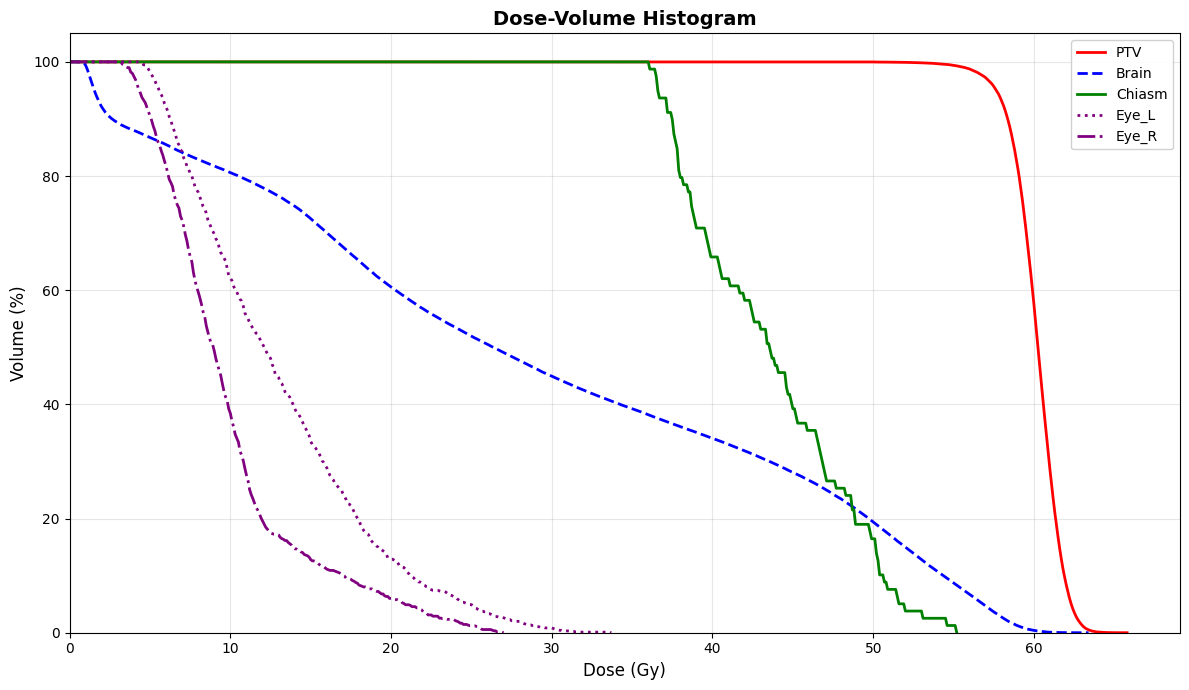

In [5]:
import matplotlib.pyplot as plt

# Structures to plot
structures_to_plot = [
    ("PTV", "red", "-"),
    ("Brain", "blue", "--"),
    ("BrainStem", "orange", "-"),
    ("Chiasm", "green", "-"),
    ("Eye_L", "purple", ":"),
    ("Eye_R", "purple", "-.")
]

fig, ax = plt.subplots(figsize=(12, 7))

for structure_name, color, linestyle in structures_to_plot:
    if structure_name in structures:
        structure = structures.get_structure(structure_name)
        dose_bins, volume_pcts = dvh.compute_dvh(dose, structure)
        
        ax.plot(
            dose_bins,
            volume_pcts,
            label=structure_name,
            color=color,
            linestyle=linestyle,
            linewidth=2
        )

ax.set_xlabel("Dose (Gy)", fontsize=12)
ax.set_ylabel("Volume (%)", fontsize=12)
ax.set_title("Dose-Volume Histogram", fontsize=14, fontweight='bold')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, None)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

## 5. Checking Dose Constraints

Evaluate whether a treatment plan meets clinical dose constraints.

In [6]:
# Define clinical constraints (example values)
constraints = {
    "PTV": {
        "D95_min": 50.0,  # At least 50 Gy to 95% of target
        "D2_max": 70.0,   # No more than 70 Gy to hottest 2%
    },
    "BrainStem": {
        "max": 54.0,      # Max dose ≤ 54 Gy
    },
    "Chiasm": {
        "max": 54.0,      # Max dose ≤ 54 Gy
    },
    "Eye_L": {
        "max": 45.0,      # Max dose ≤ 45 Gy
    },
    "Eye_R": {
        "max": 45.0,      # Max dose ≤ 45 Gy
    },
}

# Check compliance
print("Dose Constraint Compliance:")
print(f"{'Structure':20s} {'Constraint':25s} {'Value':>10s} {'Limit':>10s} {'Status':>10s}")
print("="* 80)

all_pass = True
for structure_name, struct_constraints in constraints.items():
    if structure_name not in structures:
        continue
    
    structure = structures.get_structure(structure_name)
    stats_struct = statistics.compute_dose_statistics(dose, structure)
    
    for constraint_name, limit in struct_constraints.items():
        if constraint_name == "max":
            value = stats_struct['max_dose']
            passed = value <= limit
            constraint_str = "Max dose"
        elif constraint_name == "D95_min":
            value = stats_struct['D95']
            passed = value >= limit
            constraint_str = "D95 ≥"
        elif constraint_name == "D2_max":
            value = stats_struct['D02']
            passed = value <= limit
            constraint_str = "D2 ≤"
        else:
            continue
        
        status = "✓ PASS" if passed else "✗ FAIL"
        all_pass = all_pass and passed
        
        print(f"{structure_name:20s} {constraint_str:25s} {value:10.2f} {limit:10.2f} {status:>10s}")

print("="* 80)
print(f"Overall: {'✓ ALL CONSTRAINTS MET' if all_pass else '✗ SOME CONSTRAINTS VIOLATED'}")

Dose Constraint Compliance:
Structure            Constraint                     Value      Limit     Status
PTV                  D95 ≥                          57.66      50.00     ✓ PASS
PTV                  D2 ≤                           62.81      70.00     ✓ PASS
Chiasm               Max dose                       55.16      54.00     ✗ FAIL
Eye_L                Max dose                       33.62      45.00     ✓ PASS
Eye_R                Max dose                       26.93      45.00     ✓ PASS
Overall: ✗ SOME CONSTRAINTS VIOLATED


## 6. Comparing Treatment Plans

Compare dosimetric metrics between two different treatment plans.

In [8]:
# Load two plans
plan1_path = data_path / "longitudinal" / "time_point_1"
plan2_path = data_path / "longitudinal" / "time_point_2"

dose1 = Dose.from_nifti(plan1_path / "Dose.nii.gz", name="Plan1")
structures1 = load_structure_set(plan1_path)
dose2 = Dose.from_nifti(plan2_path / "Dose.nii.gz", name="Plan2")
structures2 = load_structure_set(plan2_path)

# Compare for key structures
compare_structures = ["Brainstem", "Chiasm", "Eye_L", "Eye_R"]

print("Plan Comparison:")
print(f"{'Structure':15s} {'Metric':10s} {'Plan 1':>10s} {'Plan 2':>10s} {'Difference':>12s}")
print("="* 65)

for struct_name in compare_structures:
    if struct_name in structures1 and struct_name in structures2:
        struct1 = structures1.get_structure(struct_name)
        struct2 = structures2.get_structure(struct_name)
        
        stats1 = statistics.compute_dose_statistics(dose1, struct1)
        stats2 = statistics.compute_dose_statistics(dose2, struct2)
        
        # Compare mean dose
        diff_mean = stats2['mean_dose'] - stats1['mean_dose']
        print(f"{struct_name:15s} {'Mean':10s} {stats1['mean_dose']:10.2f} {stats2['mean_dose']:10.2f} {diff_mean:+12.2f}")
        
        # Compare max dose
        diff_max = stats2['max_dose'] - stats1['max_dose']
        print(f"{' ':15s} {'Max':10s} {stats1['max_dose']:10.2f} {stats2['max_dose']:10.2f} {diff_max:+12.2f}")
        print()

Plan Comparison:
Structure       Metric         Plan 1     Plan 2   Difference
Brainstem       Mean            14.47      15.08        +0.61
                Max             55.57      53.32        -2.25

Chiasm          Mean            43.69      39.94        -3.75
                Max             55.16      54.74        -0.41

Eye_L           Mean            13.06      14.05        +0.99
                Max             33.62      30.59        -3.03

Eye_R           Mean             9.88      10.39        +0.51
                Max             26.93      28.44        +1.51



## 8. Computing Quality Indices

Quality indices provide a single metric to assess plan quality.

In [9]:
# Compute conformity and homogeneity indices for target
ptv = structures.get_structure("PTV")
stats_target = statistics.compute_dose_statistics(dose, ptv)

# Homogeneity Index (HI) = (D2 - D98) / D50
# Lower is better (more homogeneous)
d2 = stats_target['D02']
d98 = stats_target['D98']
d50 = stats_target['D50']
hi = (d2 - d98) / d50 if d50 > 0 else 0

print("PTV Quality Indices:")
print(f"  Homogeneity Index (HI): {hi:.3f}")
print(f"    D2:  {d2:.2f} Gy")
print(f"    D98: {d98:.2f} Gy")
print(f"    D50: {d50:.2f} Gy")
print(f"\n  Interpretation:")
if hi < 0.15:
    print(f"    ✓ Excellent homogeneity (HI < 0.15)")
elif hi < 0.25:
    print(f"    ✓ Good homogeneity (0.15 ≤ HI < 0.25)")
else:
    print(f"    ! May need improvement (HI ≥ 0.25)")

# Coverage metrics
v95 = dvh.compute_volume_at_dose(dose, ptv, d50 * 0.95)
print(f"\n  Coverage:")
print(f"    V95%: {v95:.1f}% of target receives ≥95% of prescription")
if v95 >= 95:
    print(f"    ✓ Excellent coverage (V95% ≥ 95%)")
elif v95 >= 90:
    print(f"    ✓ Acceptable coverage (90% ≤ V95% < 95%)")
else:
    print(f"    ! May need improvement (V95% < 90%)")

PTV Quality Indices:
  Homogeneity Index (HI): 0.103
    D2:  62.81 Gy
    D98: 56.57 Gy
    D50: 60.25 Gy

  Interpretation:
    ✓ Excellent homogeneity (HI < 0.15)

  Coverage:
    V95%: 96.6% of target receives ≥95% of prescription
    ✓ Excellent coverage (V95% ≥ 95%)


## Summary

In this notebook, you learned how to:

1. ✓ Compute Dose-Volume Histograms (DVH)
2. ✓ Extract dosimetric parameters (Dx, Vx)
3. ✓ Analyze organs at risk
4. ✓ Visualize DVHs
5. ✓ Check dose constraint compliance
6. ✓ Compare predicted vs actual doses
7. ✓ Compare treatment plans
8. ✓ Compute quality indices

## Next Steps

- **Exporting Results**: Generate reports, CSV files, and publication-ready plots
- **Batch Processing**: Analyze multiple patients at once
- **Advanced Analysis**: Gamma analysis, geometric comparisons, statistical testing

## References

- [DoseMetrics Documentation](https://contouraid.github.io/dosemetrics/)
- [DVH Analysis Guide](https://contouraid.github.io/dosemetrics/user-guide/dvh-analysis/)
- [GitHub Repository](https://github.com/contouraid/dosemetrics)